In [1]:
!pip install tensorflow-datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 73.3 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.5/146.5 kB 32.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.0/223.0 kB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 72.7 MB/s eta 0:00:00
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21486 sha256=ea8af395b4f7b60a46dab712cac7fe1d4cd79e9eac57372e2c55b9466b9f2b34
  Stored in directory: /root/.cache/pip/wheels/e1/e8/83/ddea66100678d139b14bc87692ece57c6a2a937956d2532608
Successfully built promise
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.4
    Uninstalling protobuf-3.19.4:
      Successfully uninstalled protobuf-3.19.4
  Attempting uninst

In [2]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
import tensorflow_datasets as tfds

# To Avoid GPU errors
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    "mnist",
    split=["train", "test"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True #To get ds info
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [4]:
ds_info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='/root/tensorflow_datasets/mnist/3.0.1.incompleteGTPEZB',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }"""

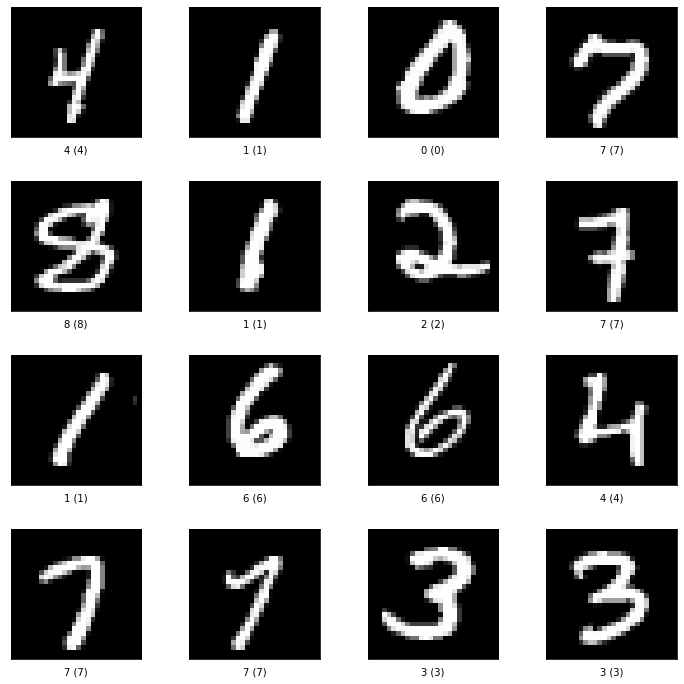

In [5]:
fig = tfds.show_examples(ds_train, ds_info, rows=4, cols=4)

In [6]:
def normalize_img(image, label):
    #normalize images
    return tf.cast(image, tf.float32)/255.0, label

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = ds_train.map(normalize_img, num_parallel_calls=AUTOTUNE)

In [8]:
BATCH_SIZE = 64
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits["train"].num_examples)
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(AUTOTUNE)

In [9]:
ds_test = ds_test.map(normalize_img, num_parallel_calls=AUTOTUNE)
ds_test = ds_test.batch(128)
ds_train = ds_train.prefetch(AUTOTUNE)

In [10]:
model = keras.Sequential([
    keras.Input((28, 28, 1)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Flatten(),
    layers.Dense(10)
])

In [11]:
model.compile(
    optimizer = keras.optimizers.Adam(lr=0.001),
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [12]:
model.fit(ds_train, epochs=5, verbose=2)

Epoch 1/5
938/938 - 11s - loss: 0.2113 - accuracy: 0.9403 - 11s/epoch - 12ms/step
Epoch 2/5
938/938 - 2s - loss: 0.0745 - accuracy: 0.9787 - 2s/epoch - 3ms/step
Epoch 3/5
938/938 - 2s - loss: 0.0528 - accuracy: 0.9843 - 2s/epoch - 3ms/step
Epoch 4/5
938/938 - 2s - loss: 0.0402 - accuracy: 0.9881 - 2s/epoch - 2ms/step
Epoch 5/5
938/938 - 2s - loss: 0.0326 - accuracy: 0.9901 - 2s/epoch - 3ms/step


In [13]:
model.evaluate(ds_test)

79/79 [==============================] - 1s 9ms/step - loss: 0.0615 - accuracy: 0.9807


[0.06151261553168297, 0.9807000160217285]

In [14]:
(ds_train, ds_test), ds_info = tfds.load(
    "imdb_reviews",
    split = ['train', 'test'],
    shuffle_files = True,
    as_supervised = True,
    with_info =True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteSFTZ63/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteSFTZ63/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteSFTZ63/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [15]:
print(ds_info)

tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset. This is a dataset for binary sentiment
    classification containing substantially more data than previous benchmark
    datasets. We provide a set of 25,000 highly polar movie reviews for training,
    and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_path=PosixGPath('/tmp/tmpx5b5jubktfds'),
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
        'text': Text(shape=(), dtype=string),
    }),
    supervised_keys=('text', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=25000, num_shards=1>,
        'train': <SplitInf

In [16]:
for text, label in ds_train:
    print(text)
    break

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)


In [17]:
tokenizer = tfds.deprecated.text.Tokenizer()

In [18]:
def build_vocabulary():
    vocabulary = set()
    for text, _ in ds_train:
        vocabulary.update(tokenizer.tokenize(text.numpy().lower()))
    return vocabulary

In [19]:
vocabulary = build_vocabulary()

In [20]:
encoder = tfds.deprecated.text.TokenTextEncoder(vocabulary, oov_token="<UNK>", lowercase=True, tokenizer=tokenizer)

In [21]:
def my_encoding(text_tensor, label):
    return encoder.encode(text_tensor.numpy()), label

In [23]:
def encode_map(text, label):
    encoded_text, label = tf.py_function(
        my_encoding, [text, label], Tout = (tf.int64, tf.int64)
    )
    encoded_text.set_shape([None])
    label.set_shape([])
    return encoded_text, label 

In [24]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = ds_train.map(encode_map, num_parallel_calls=AUTOTUNE).cache()
ds_train = ds_train.shuffle(10000)
ds_train = ds_train.padded_batch(32, padded_shapes=([None], ()))
ds_train = ds_train.prefetch(AUTOTUNE)

In [25]:
ds_test = ds_test.map(encode_map)
ds_test = ds_test.padded_batch(32, padded_shapes=([None], ()))


In [26]:
model = keras.Sequential([
    layers.Masking(mask_value=0),
    layers.Embedding(input_dim=len(vocabulary) + 2, output_dim=32), #Batch_size x 1000 -> Batch_size x 1000 x 32 
    layers.GlobalAveragePooling1D(), #Batch_size x 1000 x 32 ->  #Batch_size x 32
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

In [28]:
model.compile(
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(3e-4, clipnorm=1),
    metrics=['accuracy']
)

In [29]:
model.fit(ds_train, epochs=10, verbose=2)

Epoch 1/10
782/782 - 25s - loss: 0.6750 - accuracy: 0.5052 - 25s/epoch - 32ms/step
Epoch 2/10
782/782 - 3s - loss: 0.4955 - accuracy: 0.7205 - 3s/epoch - 4ms/step
Epoch 3/10
782/782 - 3s - loss: 0.3395 - accuracy: 0.8608 - 3s/epoch - 4ms/step
Epoch 4/10
782/782 - 3s - loss: 0.2698 - accuracy: 0.8935 - 3s/epoch - 4ms/step
Epoch 5/10
782/782 - 3s - loss: 0.2303 - accuracy: 0.9108 - 3s/epoch - 4ms/step
Epoch 6/10
782/782 - 3s - loss: 0.1997 - accuracy: 0.9242 - 3s/epoch - 4ms/step
Epoch 7/10
782/782 - 3s - loss: 0.1761 - accuracy: 0.9365 - 3s/epoch - 4ms/step
Epoch 8/10
782/782 - 4s - loss: 0.1548 - accuracy: 0.9451 - 4s/epoch - 4ms/step
Epoch 9/10
782/782 - 3s - loss: 0.1389 - accuracy: 0.9525 - 3s/epoch - 4ms/step
Epoch 10/10
782/782 - 3s - loss: 0.1224 - accuracy: 0.9584 - 3s/epoch - 4ms/step


In [30]:
model.evaluate(ds_test)

782/782 [==============================] - 24s 31ms/step - loss: 0.2933 - accuracy: 0.8847


[0.2932998538017273, 0.8846799731254578]